In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import pickle as pkl
from lib.utils import *
from copy import deepcopy as dcp
from os import walk
import shutil
from lib.Wilson_Cowan.parameters_info import parameter_names, parameters_lower_bound,parameters_range_bounds
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'

# CMA-ES

In [2]:
cma_p = '../Data/WC/search_tests/cmaes/'
num_std_tested = [1]
init_files = []
runtime_CMA = [[] for _ in range(2)]
all_std_errors = [[] for _ in range(2)]
cma_fits = [[] for _ in range(2)]
cma_fs = ['cmaes_25chk_100rd_all_best_final25repeats_0']
for iii, cma_f in enumerate(cma_fs):
    cmaes_log = get_log(cma_p,cma_f)
    for ii in range(2):
        start_index = ii * 20
        init_file_to_search = cmaes_log[start_index]['settings']['init_file']
        print(init_file_to_search)
        init_files.append(init_file_to_search)
        for j in range(num_std_tested[iii]):
            cmaes_errors = []
            cmaes_fits = []
            run_time = []
            sigma = cmaes_log[start_index+j]['settings']['sigma0']
            for i in range(20):
                errors = -cmaes_log[start_index+i]['fit_history']['error']
                fits = cmaes_log[start_index+i]['best_fit']['x']
                run_time.append(cmaes_log[start_index+i]['overall_runtime'])
                cmaes_errors.append(errors)
                cmaes_fits.append(fits)
            cmaes_errors = torch.cat(cmaes_errors, dim = 0).mean(-1)
            cmaes_fits = torch.cat(cmaes_fits, dim = 0)
            all_std_errors[ii].append(cmaes_errors)
            cma_fits[ii].append(cmaes_fits)
            run_time = torch.cat(run_time, dim = 0).mean(-1)
            runtime_CMA[ii].append(run_time.numpy())
print(all_std_errors[0][0].shape)

new_init/cube_10000_0
new_init/cube_10000_1
torch.Size([20, 25, 101])


# PSO

In [3]:
global_search_path_PSO = '../Data/WC/search_tests/PSO/'
PSO_paths = [
    'cube_10000_0-20targets_distsphere_blw0.15_chunk25_100rds_w0.7_c2.25_c2.25_PSO_0',
    'cube_10000_1-20targets_distsphere_blw0.15_chunk25_100rds_w0.9_c1.5_c1.5_PSO_0',
]
target_indices = [i for i in range(0,20)]
search_logs = [get_log(global_search_path_PSO, PSO_paths[i]) for i in range(len(PSO_paths))]
runtime_PSO = [search_logs[i][0]['overall_runtime'].squeeze().numpy() for i in range(len(PSO_paths))]
errors = [-search_logs[i][0]['fit_history']['error'][target_indices].mean(-1).numpy() for i in range(len(PSO_paths))]
pso_fits = [search_logs[i][0]['best_fit']['x'][target_indices] for i in range(len(PSO_paths))]
best_PSO_mean_errors = [errors[i].mean(1, keepdims = True).mean(0, keepdims = True) for i in range(len(PSO_paths))]
best_PSO_std_errors = [[(best_PSO_mean_errors[i]-errors[i].std(1).mean(0)).squeeze(),
                      (best_PSO_mean_errors[i]+errors[i].std(1).mean(0)).squeeze()] for i in range(len(PSO_paths))]

# Random search based

In [6]:
global_search_path = '../Data/WC/search_tests/simple/'
final_files = [
        ['cube_10000_0-20targets_w0.0_blw0.125_chunk25_100rds_0dim_5LD_pure', 0],
		['cube_10000_0-20targets_w0.0_blw0.1_chunk25_100rds_0dim_5LD_SA', 1],
		['cube_10000_0-20targets_w0.15_blw0.0_chunk25_100rds_8dim_5LD_pure_AE', 2],
		['cube_10000_0-20targets_w0.15_blw0.0_chunk25_100rds_10dim_5LD_pure_PCA', 3],
		['cube_10000_0-20targets_w0.15_blw0.0_chunk25_100rds_11dim_5LD_SA_AE', 4],
		['cube_10000_0-20targets_w0.15_blw0.0_chunk25_100rds_10dim_5LD_SA_PCA', 5],
],[
		['cube_10000_1-20targets_w0.0_blw0.1_chunk25_100rds_0dim_5LD_pure', 0],
		['cube_10000_1-20targets_w0.0_blw0.125_chunk25_100rds_0dim_5LD_SA', 1],
		['cube_10000_1-20targets_w0.15_blw0.0_chunk25_100rds_8dim_5LD_pure_AE', 2],
		['cube_10000_1-20targets_w0.15_blw0.0_chunk25_100rds_10dim_5LD_pure_PCA', 3],
		['cube_10000_1-20targets_w0.175_blw0.0_chunk25_100rds_11dim_5LD_SA_AE', 4],
		['cube_10000_1-20targets_w0.15_blw0.0_chunk25_100rds_12dim_5LD_SA_PCA', 5],
]

target_indices = [i for i in range(20)]
results = []
rs_fits = []
runtime_RS = []
all_settings = []
random_search_paths = final_files
for ii in range(len(random_search_paths)):
    if random_search_paths[ii] is None:
        results.append(None)
        continue
    other_error = [None for _ in range(6)]
    best_other_error = [None for _ in range(6)]
    fits_rs = [None for _ in range(6)]
    best_other_std_errors = [None for _ in range(6)]
    settings = [None for _ in range(6)]
    rt = [None for _ in range(6)]
    for j, path in enumerate(random_search_paths[ii]):
        file_er = get_log(global_search_path, path[0])
        try:
            err = -file_er[path[1]]['fit_history']['error'][target_indices][:,:,:101,:].mean(-1).numpy()
            fits_rs[path[1]] = file_er[path[1]]['best_fit']['x'][target_indices]
            rt[path[1]] = file_er[path[1]]['overall_runtime'].squeeze().numpy()
            settings[path[1]] = file_er[path[1]]['settings']
            other_error[path[1]] = err
            mean_err = err.mean(1, keepdims = True).mean(0, keepdims = True)
            best_other_error[path[1]] = mean_err
            best_other_std_errors[path[1]] = [(mean_err-err.std(1).mean(0)).squeeze(),
                              (mean_err+err.std(1).mean(0)).squeeze()]
        except:
            print(path)
            pass
    results.append([best_other_error, best_other_std_errors])
    rs_fits.append(fits_rs)
    runtime_RS.append(rt)
    all_settings.append(settings)

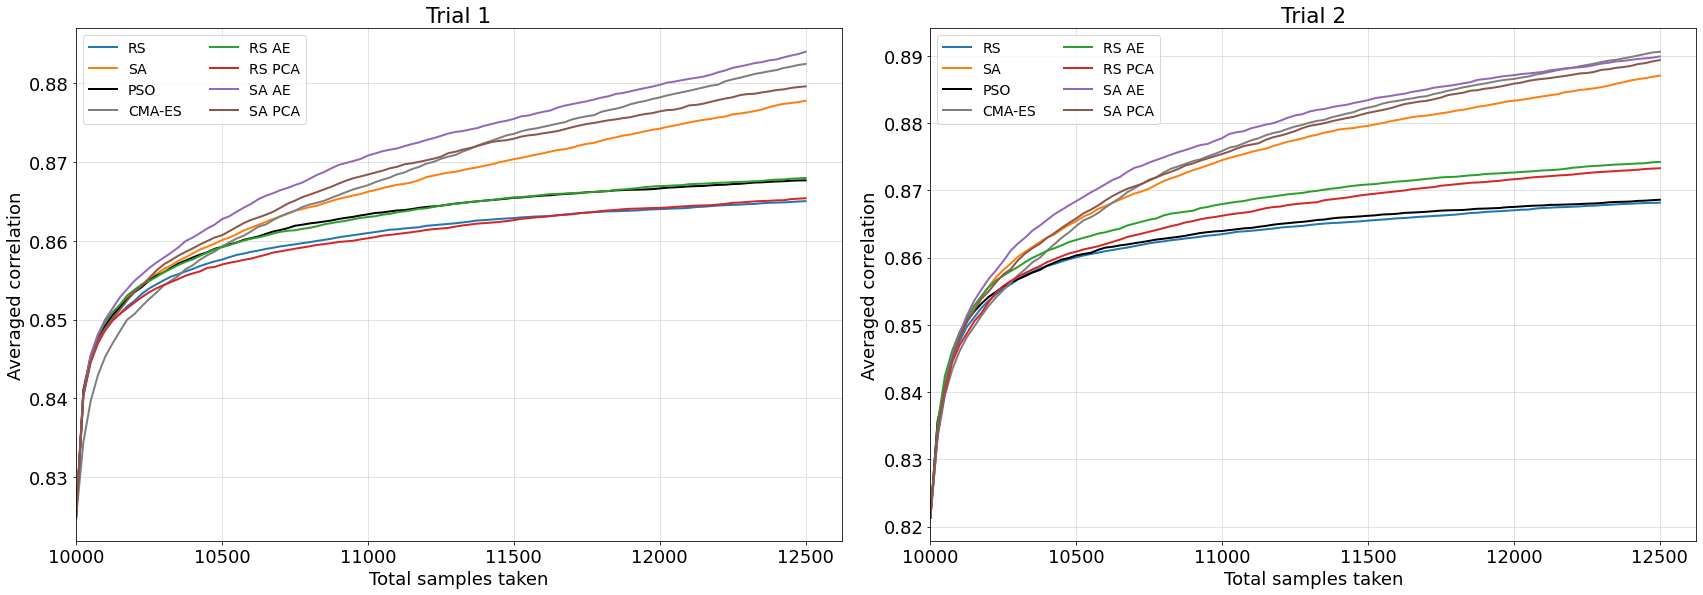

In [7]:
start = 0
titles = ['Trial 1', 'Trial 2']
loss_fn = 'correlation'
initial_samp = [10000, 10000]
num_rounds = 100
hide_pure = True
lim = num_rounds-start+1
labels = ['RS','SA','RS AE', 'RS PCA', 'SA AE', 'SA PCA']
cmae_stds = [0,0]
markers = [f'-r',f'--r','-C7',f'--C7',None,None]
ncol = 2
f = plt.figure(figsize=(24, 8* (len(results)//ncol +1)))
for i in range(len(results)):
    ax = plt.subplot(len(results)//ncol +1,ncol,i+1)
    cmae_std = cmae_stds[i]
    cmae_num = i
    if results[i] is not None:
        best_other_error = results[i][0]
        best_other_std_errors = results[i][1]
        color_num = 0
        for ii in range(0,2):
            lim = num_rounds-start+1
            samples = [initial_samp[i]+25*j for j in range(num_rounds+1)]
            plt.plot(samples,best_other_error[ii][:,:,:lim].squeeze(), f'-C{color_num}', label = f"{labels[ii]}")
            color_num+=1
    try:
        samples = [initial_samp[i]+ 25*j for j in range(num_rounds+1)]
        plt.plot(samples,best_PSO_mean_errors[i][:,:,:lim].squeeze(), '-k', label = f"PSO")
        plt.plot([initial_samp[i]+25*j for j in range(num_rounds+1)],all_std_errors[cmae_num][cmae_std][:].mean(1).mean(0).numpy(),'-C7', label = f'CMA-ES')
    except:
        pass
    if results[i] is not None:
        best_other_error = results[i][0]
        best_other_std_errors = results[i][1]
        for ii in range(2,6):
            lim = num_rounds-start+1
            samples = [initial_samp[i]+25*j for j in range(num_rounds+1)]
            plt.plot(samples,best_other_error[ii][:,:,:lim].squeeze(), f'-C{color_num}', label = f"{labels[ii]}")
            color_num+=1
    plt.xlim([initial_samp[i], None])
    plt.title(f'{titles[i]}')
    plt.ylabel(f"Averaged {loss_fn}")
    plt.xlabel("Total samples taken")
    plt.legend(ncol = 2, prop = {'size':14})
    plt.grid(linestyle = "--", linewidth = 0.5)
plt.tight_layout()
plt.show()

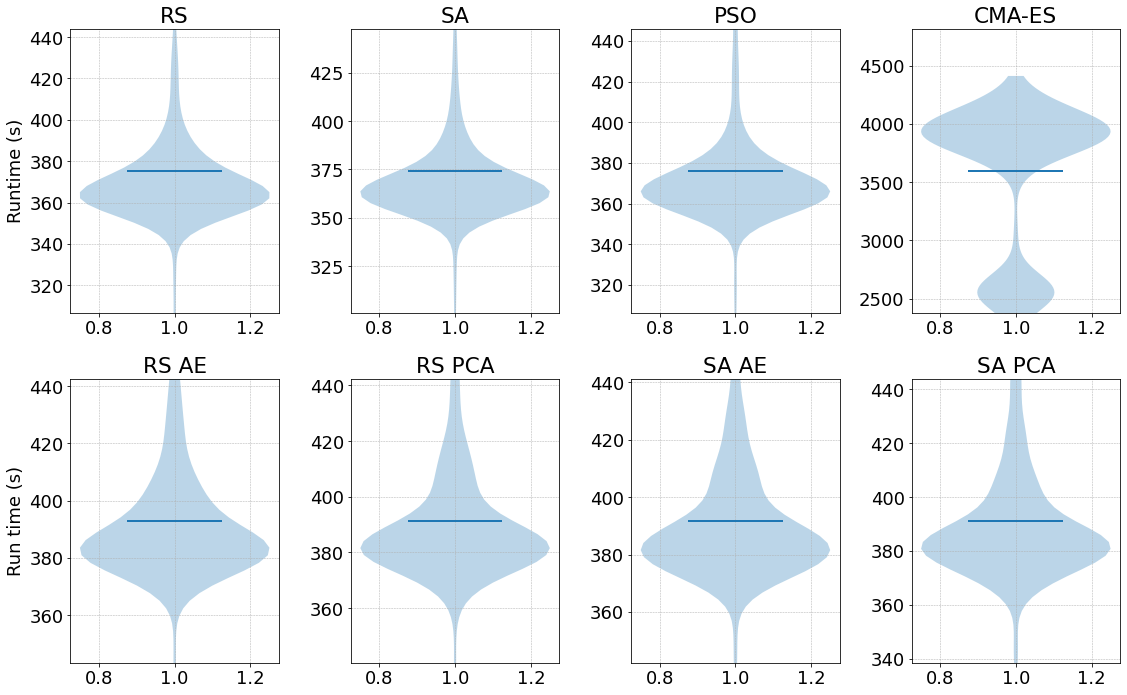

In [8]:
all_runtime_RS = [np.concatenate([runtime_RS[i][j].reshape((-1)) for i in range(2)]) for j in range(6)]
all_runtime_PSO = np.concatenate([ensure_numpy(runtime_PSO[i]).reshape((-1)) for i in range(2)])
all_runtime_CMA= np.concatenate([ensure_numpy(runtime_CMA[i][cmae_stds[i]]).reshape((-1)) for i in range(2)])
fig = plt.figure(figsize=(16,10))
for j in range(2):
    ax = plt.subplot(2,4,j+1)
    runt = ensure_numpy(all_runtime_RS[j]).reshape((-1))
    lower_b = runt.mean()-2*runt.std()
    upper_b = runt.mean()+2*runt.std()
    plt.violinplot(ensure_numpy(all_runtime_RS[j]).reshape((-1)),showmeans = True, showextrema = False)
    plt.ylim([max(lower_b,runt.min()), upper_b])
    plt.grid(linestyle = "--", linewidth = 0.5)
    if j == 0:
        plt.ylabel(f"Runtime (s)")
    plt.title(f'{labels[j]}')
ax = plt.subplot(2,4,3)
lower_b = all_runtime_PSO.mean()-2*all_runtime_PSO.std()
upper_b = all_runtime_PSO.mean()+2*all_runtime_PSO.std()
plt.violinplot(all_runtime_PSO,showmeans = True, showextrema = False)
plt.ylim([max(lower_b,all_runtime_PSO.min()), upper_b])
plt.grid(linestyle = "--", linewidth = 0.5)
plt.title(f'PSO')
ax = plt.subplot(2,4,4)
lower_b = all_runtime_CMA.mean()-2*all_runtime_CMA.std()
upper_b = all_runtime_CMA.mean()+2*all_runtime_CMA.std()
plt.violinplot(all_runtime_CMA,showmeans = True, showextrema = False)
plt.ylim([max(lower_b,all_runtime_CMA.min()), upper_b])
plt.grid(linestyle = "--", linewidth = 0.5)
plt.title(f'CMA-ES')
for j in range(2,6):
    ax = plt.subplot(2,4,j+3)
    runt = ensure_numpy(all_runtime_RS[j]).reshape((-1))
    lower_b = runt.mean()-2*runt.std()
    upper_b = runt.mean()+2*runt.std()
    plt.violinplot(runt,showmeans = True, showextrema = False)
    if j == 2:
        plt.ylabel(f"Run time (s)")
    plt.title(f'{labels[j]}')
    plt.ylim([max(lower_b,runt.min()), upper_b])
    plt.grid(linestyle = "--", linewidth = 0.5)
plt.tight_layout()
plt.show()

In [ ]:
print(pso_fits[0].shape)
print(rs_fits[0][0].shape)
print(cma_fits[0][2].shape)
targets = file_er[-1]['target'][0][:,0,0,:]

In [ ]:
freq = [2+0.5*i for i in range(156)]
labels = ['RS','SA','RS AE', 'RS PCA', 'SA AE', 'SA PCA']
fig = plt.figure(figsize=(32,100))
counter = 1
for i in range(20):
    for k in range(6):
        ax = plt.subplot(20,6,counter)
        ax.plot(freq,targets[i],'-k')
        for j in range(5):
            ax.plot(freq,rs_fits[0][k][i][j]/rs_fits[0][k][i][j].max(),'--', linewidth = 0.9)
        plt.title(f'{labels[k]} {i}')
        counter+=1
plt.tight_layout()
plt.show()